Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups # 20 News Groups Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import warnings
warnings.filterwarnings('ignore')


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

SMS Spam Collection and NewsGroup Dataset

In [2]:
# Load SMS Spam Collection Dataset
sms_data = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding='latin-1')
sms_data = sms_data[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
sms_data['label'] = sms_data['label'].map({'ham': 0, 'spam': 1})

In [3]:
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroups_df = pd.DataFrame({'text': newsgroups_data.data, 'label': newsgroups_data.target})

print("Step 1: Data Loading")
print("\n")
print("SMS Dataset Shape:", sms_data.shape)
print("Newsgroups Dataset Shape:", newsgroups_df.shape)
print("\n")
print("SMS Spam Collection Dataset:")
print(sms_data.head())
print("\n20 Newsgroups Dataset:")
print(newsgroups_df.head())

Step 1: Data Loading


SMS Dataset Shape: (5572, 2)
Newsgroups Dataset Shape: (18846, 2)


SMS Spam Collection Dataset:
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

20 Newsgroups Dataset:
                                                text  label
0  \n\nI am sure some bashers of Pens fans are pr...     10
1  My brother is in the market for a high-perform...      3
2  \n\n\n\n\tFinally you said what you dream abou...     17
3  \nThink!\n\nIt's the SCSI card doing the DMA t...      3
4  1)    I have an old Jasmine drive which I cann...      4


## Text Preprocessing

In [4]:
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        return ' '.join(clean_tokens)
    return ''

In [5]:
# Apply preprocessing to both datasets
print("Preprocessing SMS dataset...")
sms_data['processed_text'] = sms_data['message'].apply(preprocess_text)
print("Preprocessing Newsgroups dataset...")
newsgroups_df['processed_text'] = newsgroups_df['text'].apply(preprocess_text)

Preprocessing SMS dataset...
Preprocessing Newsgroups dataset...


In [6]:
print("SMS Spam Collection Dataset:")
print(sms_data.head())
print("\n20 Newsgroups Dataset:")
print(newsgroups_df.head())

SMS Spam Collection Dataset:
   label                                            message  \
0      0  Go until jurong point, crazy.. Available only ...   
1      0                      Ok lar... Joking wif u oni...   
2      1  Free entry in 2 a wkly comp to win FA Cup fina...   
3      0  U dun say so early hor... U c already then say...   
4      0  Nah I don't think he goes to usf, he lives aro...   

                                      processed_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4           nah dont think go usf life around though  

20 Newsgroups Dataset:
                                                text  label  \
0  \n\nI am sure some bashers of Pens fans are pr...     10   
1  My brother is in the market for a high-perform...      3   
2  \n\n\n\n\tFinally you said what you dream abou

In [7]:
print("SMS Dataset Shape:", sms_data.shape)
print("Newsgroups Dataset Shape:", newsgroups_df.shape)

SMS Dataset Shape: (5572, 3)
Newsgroups Dataset Shape: (18846, 3)


Splitting Dataset 60,20,20

In [8]:
# Function to split dataset
def prepare_dataset(df, text_col, label_col, train_size=0.6, val_size=0.2):
    # First split: training and temp (validation + test)
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42, stratify=df[label_col])

    # Second split: validation and test from temp
    val_ratio = val_size / (1 - train_size)
    val_df, test_df = train_test_split(temp_df, train_size=val_ratio, random_state=42, stratify=temp_df[label_col])

    return train_df, val_df, test_df

In [9]:
# Prepare both datasets
sms_train, sms_val, sms_test = prepare_dataset(sms_data, 'processed_text', 'label')
news_train, news_val, news_test = prepare_dataset(newsgroups_df, 'processed_text', 'label')

In [10]:
print("\nDataset splits:")
print(f"SMS - Train: {len(sms_train)}, Validation: {len(sms_val)}, Test: {len(sms_test)}")
print(f"News - Train: {len(news_train)}, Validation: {len(news_val)}, Test: {len(news_test)}")


Dataset splits:
SMS - Train: 3343, Validation: 1114, Test: 1115
News - Train: 11307, Validation: 3769, Test: 3770


TF-IDF Vectorization

In [13]:
# TF-IDF Vectorization
sms_vectorizer = TfidfVectorizer(max_features=5000)
sms_train_tfidf = sms_vectorizer.fit_transform(sms_train['processed_text'])
sms_val_tfidf = sms_vectorizer.transform(sms_val['processed_text'])
sms_test_tfidf = sms_vectorizer.transform(sms_test['processed_text'])

news_vectorizer = TfidfVectorizer(max_features=10000)
news_train_tfidf = news_vectorizer.fit_transform(news_train['processed_text'])
news_val_tfidf = news_vectorizer.transform(news_val['processed_text'])
news_test_tfidf = news_vectorizer.transform(news_test['processed_text'])

In [14]:
print("Step 3: TF-IDF Vectorization")
print(f"SMS TF-IDF shape: {sms_train_tfidf.shape}")
print(f"News TF-IDF shape: {news_train_tfidf.shape}")

Step 3: TF-IDF Vectorization
SMS TF-IDF shape: (3343, 5000)
News TF-IDF shape: (11307, 10000)


**Word2Vec** Word Embeddings

In [15]:
# Word Embeddings (using Word2Vec)
def get_sentence_embedding(sentence, model, vector_size=100):
    words = sentence.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    return np.zeros(vector_size)

In [16]:
# Train Word2Vec model on our corpus
sms_texts = [text.split() for text in sms_train['processed_text'] if text.strip()]
news_texts = [text.split() for text in news_train['processed_text'] if text.strip()]

sms_w2v = Word2Vec(sentences=sms_texts, vector_size=100, window=5, min_count=1, workers=4)
news_w2v = Word2Vec(sentences=news_texts, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Convert texts to embeddings
print("Converting text to embeddings...\n")
sms_train_w2v = np.array([get_sentence_embedding(text, sms_w2v) for text in sms_train['processed_text']])
sms_val_w2v = np.array([get_sentence_embedding(text, sms_w2v) for text in sms_val['processed_text']])
sms_test_w2v = np.array([get_sentence_embedding(text, sms_w2v) for text in sms_test['processed_text']])

news_train_w2v = np.array([get_sentence_embedding(text, news_w2v) for text in news_train['processed_text']])
news_val_w2v = np.array([get_sentence_embedding(text, news_w2v) for text in news_val['processed_text']])
news_test_w2v = np.array([get_sentence_embedding(text, news_w2v) for text in news_test['processed_text']])

print(f"SMS W2V embeddings shape: {sms_train_w2v.shape}")
print(f"News W2V embeddings shape: {news_train_w2v.shape}")

Converting text to embeddings...

SMS W2V embeddings shape: (3343, 100)
News W2V embeddings shape: (11307, 100)


Displaying the Vectorized form of Text

In [18]:
print("SMS Train:")
print(sms_train_w2v)
print("\nNEWS Train:")
print(news_train_w2v)

SMS Train:
[[-0.03342387  0.05119457  0.02594288 ... -0.04147855  0.00648451
  -0.0154094 ]
 [-0.03671886  0.05800563  0.03009858 ... -0.04700886  0.00892415
  -0.01725018]
 [-0.01718661  0.02127509  0.00820968 ... -0.01691031  0.00575012
  -0.00654896]
 ...
 [-0.01426272  0.02676436  0.01161909 ... -0.02236623  0.00655391
  -0.00878823]
 [-0.05003311  0.07817578  0.04004032 ... -0.06510027  0.0149571
  -0.02257304]
 [-0.03463011  0.0570325   0.02839175 ... -0.04530296  0.01040011
  -0.01614562]]

NEWS Train:
[[-0.54017377 -0.06857566 -0.22796683 ... -0.04412968 -0.53493822
   0.6030817 ]
 [-0.57848424  0.19432743 -0.22864278 ... -0.11459731 -0.4244945
   0.71506906]
 [-0.62694561  0.03743994 -0.22554615 ... -0.03879358 -0.55596197
   0.67208219]
 ...
 [-0.60466713  0.34081346 -0.08160603 ... -0.02065271 -0.68419874
   1.0673902 ]
 [-0.58563489  0.14622717 -0.20912789 ... -0.01695743 -0.49633634
   0.7205475 ]
 [-0.73705691  0.39674172 -0.10264923 ...  0.06149872 -0.66276383
   1.01597

## Function to Evaluate Models, it includes
*   Evaluation Metrics (Accuracy, Prescision, Recall, F1-score, ROC-AUC score)
*   Classification Report
*   Confusion Matrix
*   ROC plots for Binary Classification only


In [19]:
def evaluate_model(y_true, y_pred, y_prob=None, model_name="Model", is_binary=True):
    accuracy = accuracy_score(y_true, y_pred)

    if is_binary:
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        sensitivity = recall  # Sensitivity is the same as recall/true positive rate
        # Calculate specificity (true negative rate)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp)
        f1 = f1_score(y_true, y_pred)
        if y_prob is not None:
            try:
                roc_auc = roc_auc_score(y_true, y_prob)
            except:
                roc_auc = None
        else:
            roc_auc = None
    else:
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        sensitivity = recall  # For multiclass, sensitivity per class can be found in classification report
        specificity = None  # Specificity for multiclass requires one-vs-rest calculation
        f1 = f1_score(y_true, y_pred, average='weighted')
        roc_auc = None  # ROC-AUC not applicable for multiclass directly

    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    if is_binary:
        print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC Score: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("\n")

    # If binary and probabilities available, plot ROC curve
    if is_binary and y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'sensitivity': sensitivity,
        'specificity': specificity if is_binary else None,
        'f1': f1,
        'roc_auc': roc_auc
    }

## Spam Detection Models


*   Naive Bayes
*   SVM
*   Logistic Regression
*   ANN model



In [20]:
# Let's implement and evaluate each model for SMS Spam dataset
print("\n====== SMS Spam Detection Models ======")


====== SMS Spam Detection Models ======



1. Naive Bayes Classifier (TF-IDF features)

Naive Bayes (SMS) Evaluation Metrics:
Accuracy: 0.9614
Precision: 0.9908
Recall: 0.7200
Sensitivity: 0.7200
Specificity: 0.9990
F1 Score: 0.8340
ROC-AUC Score: 0.9829

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       0.99      0.72      0.83       150

    accuracy                           0.96      1115
   macro avg       0.97      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



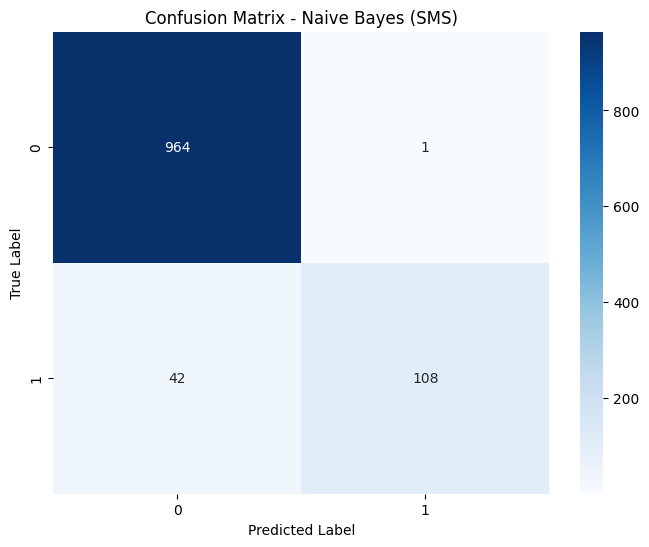

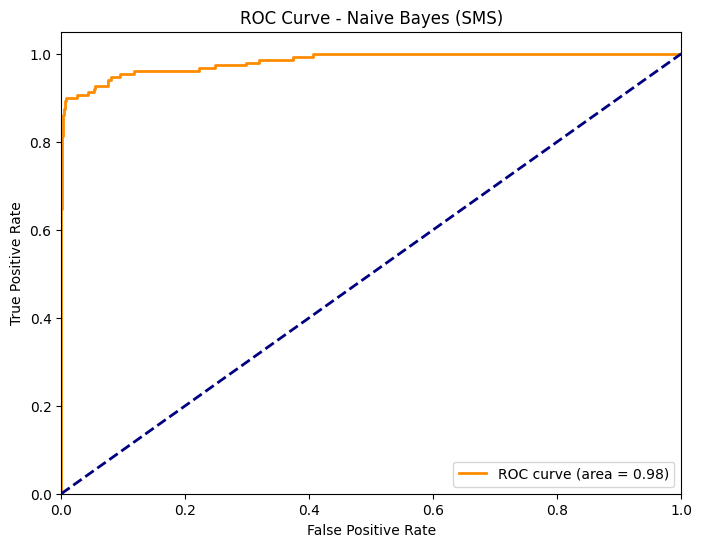

In [21]:
# 1. Naive Bayes
print("\n1. Naive Bayes Classifier (TF-IDF features)")
nb_model = MultinomialNB()
nb_model.fit(sms_train_tfidf, sms_train['label'])
nb_preds = nb_model.predict(sms_test_tfidf)
nb_probs = nb_model.predict_proba(sms_test_tfidf)[:, 1]
nb_metrics = evaluate_model(sms_test['label'], nb_preds, nb_probs, "Naive Bayes (SMS)")


2. Support Vector Machine (TF-IDF features)

SVM (SMS) Evaluation Metrics:
Accuracy: 0.9839
Precision: 0.9714
Recall: 0.9067
Sensitivity: 0.9067
Specificity: 0.9959
F1 Score: 0.9379
ROC-AUC Score: 0.9898

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.97      0.91      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



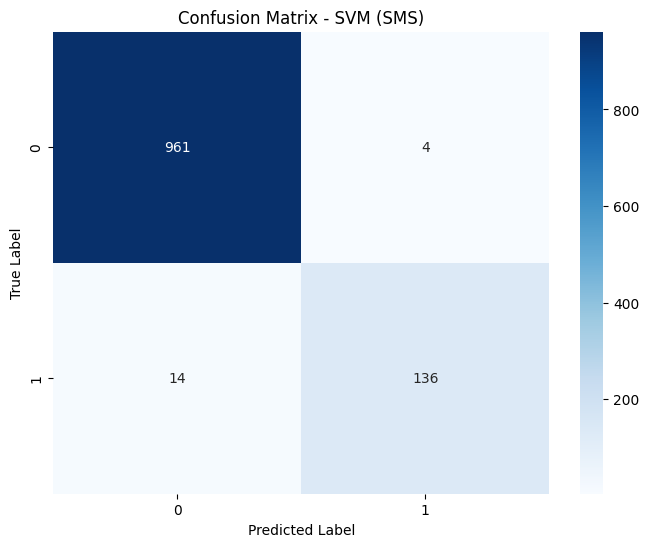

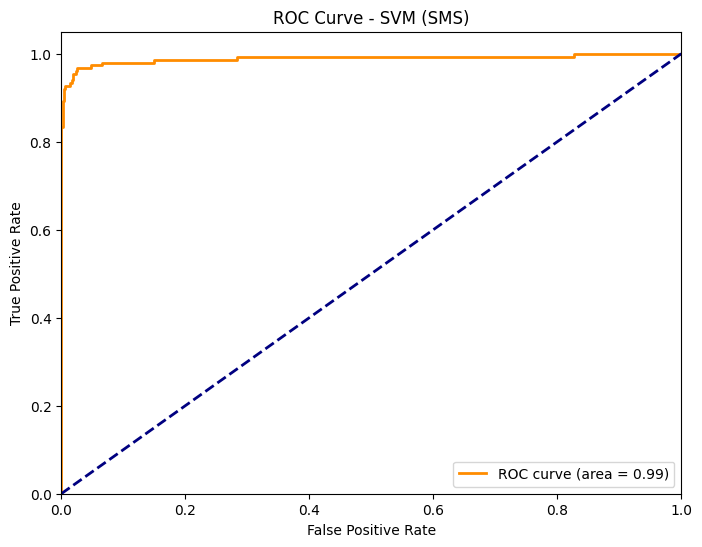

In [22]:
# 2. SVM
print("\n2. Support Vector Machine (TF-IDF features)")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(sms_train_tfidf, sms_train['label'])
svm_preds = svm_model.predict(sms_test_tfidf)
svm_probs = svm_model.predict_proba(sms_test_tfidf)[:, 1]
svm_metrics = evaluate_model(sms_test['label'], svm_preds, svm_probs, "SVM (SMS)")


3. Logistic Regression (TF-IDF features)

Logistic Regression (SMS) Evaluation Metrics:
Accuracy: 0.9534
Precision: 0.9712
Recall: 0.6733
Sensitivity: 0.6733
Specificity: 0.9969
F1 Score: 0.7953
ROC-AUC Score: 0.9930

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.97      0.67      0.80       150

    accuracy                           0.95      1115
   macro avg       0.96      0.84      0.88      1115
weighted avg       0.95      0.95      0.95      1115



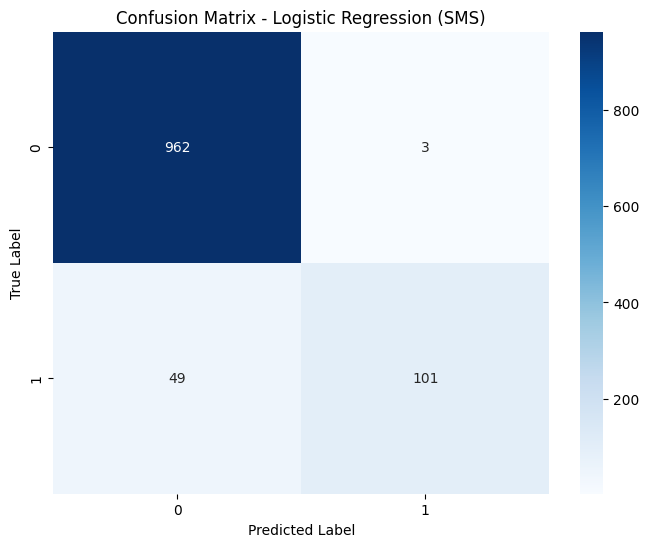

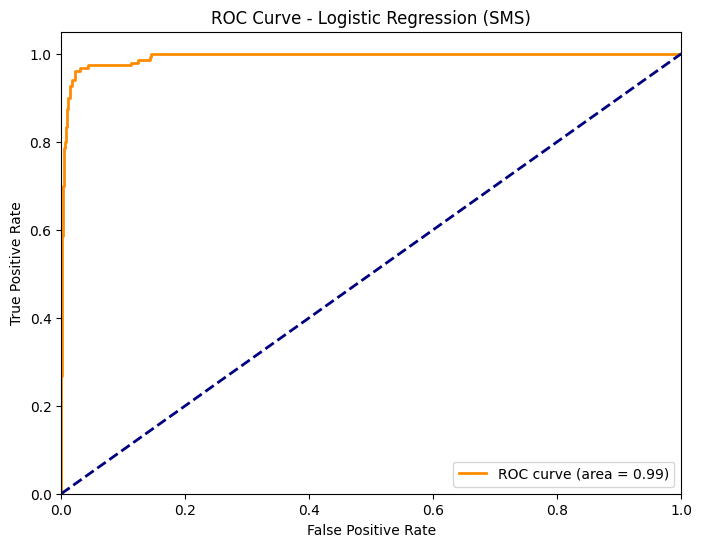

In [23]:
# 3. Logistic Regression
print("\n3. Logistic Regression (TF-IDF features)")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(sms_train_tfidf, sms_train['label'])
lr_preds = lr_model.predict(sms_test_tfidf)
lr_probs = lr_model.predict_proba(sms_test_tfidf)[:, 1]
lr_metrics = evaluate_model(sms_test['label'], lr_preds, lr_probs, "Logistic Regression (SMS)")

In [24]:
# 4. Neural Network (using Word2Vec embeddings)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [25]:
# Build the neural network
nn_model_sms = Sequential([
    Dense(128, activation='relu', input_shape=(sms_train_w2v.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_model_sms.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
# Train the model
history = nn_model_sms.fit(
    sms_train_w2v, sms_train['label'],
    validation_data=(sms_val_w2v, sms_val['label']),
    epochs=100,
    batch_size=32,
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7940 - loss: 0.5430 - val_accuracy: 0.8662 - val_loss: 0.4033
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8703 - loss: 0.3909 - val_accuracy: 0.8662 - val_loss: 0.3848
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8740 - loss: 0.3771 - val_accuracy: 0.8662 - val_loss: 0.3808
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8613 - loss: 0.3955 - val_accuracy: 0.8662 - val_loss: 0.3792
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8743 - loss: 0.3728 - val_accuracy: 0.8662 - val_loss: 0.3818
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.3766 - val_accuracy: 0.8662 - val_loss: 0.3774
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8551 - loss: 0.3925 - val_accuracy: 0.8662 - val_loss: 0.3770
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8641 - loss: 0.3803 - val_accu

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Neural Network (SMS) Evaluation Metrics:
Accuracy: 0.9193
Precision: 0.7000
Recall: 0.7000
Sensitivity: 0.7000
Specificity: 0.9534
F1 Score: 0.7000
ROC-AUC Score: 0.9259

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       965
           1       0.70      0.70      0.70       150

    accuracy                           0.92      1115
   macro avg       0.83      0.83      0.83      1115
weighted avg       0.92      0.92      0.92      1115



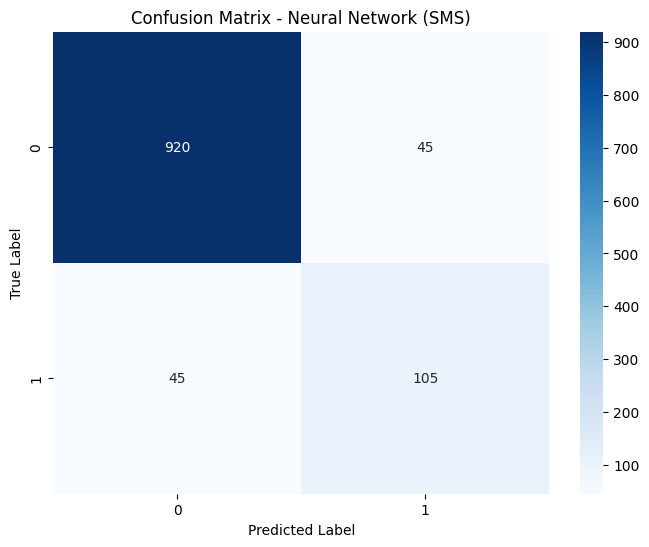

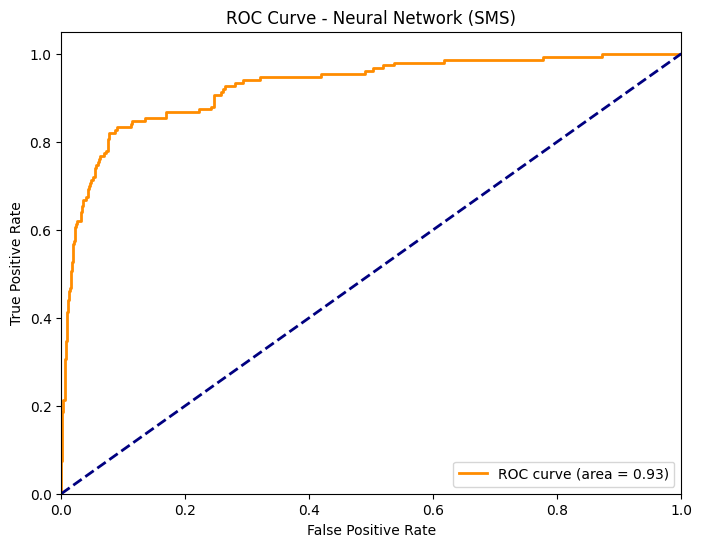

In [27]:
# Evaluate the model
nn_preds_prob = nn_model_sms.predict(sms_test_w2v)
nn_preds = (nn_preds_prob > 0.5).astype(int)
nn_metrics = evaluate_model(sms_test['label'], nn_preds.flatten(), nn_preds_prob.flatten(), "Neural Network (SMS)")

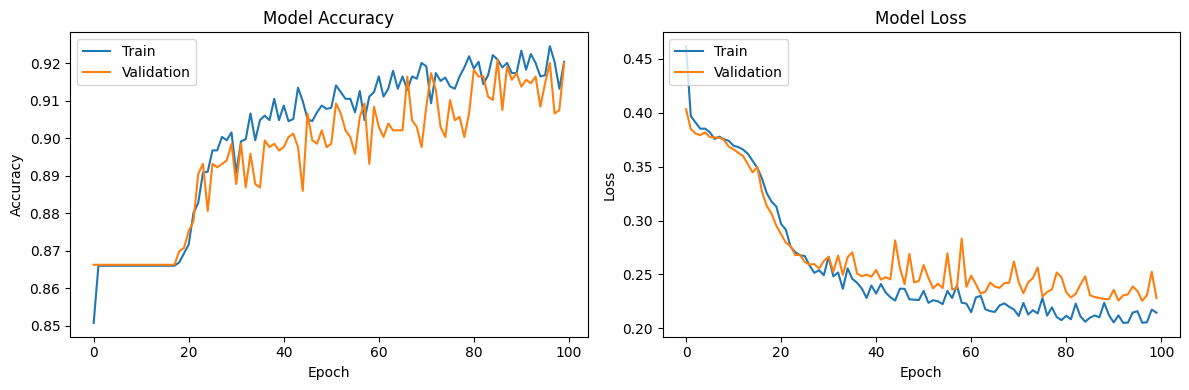

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

## News Detection Models


*   Naive Bayes
*   SVM
*   Logistic Regression
*   ANN model


In [29]:
# Now implement models for 20 Newsgroups dataset
print("\n====== 20 Newsgroups Classification Models ======")


====== 20 Newsgroups Classification Models ======



1. Naive Bayes Classifier (TF-IDF features)

Naive Bayes (Newsgroups) Evaluation Metrics:
Accuracy: 0.7037
Precision: 0.7233
Recall: 0.7037
Sensitivity: 0.7037
F1 Score: 0.6911

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.34      0.47       160
           1       0.62      0.66      0.64       194
           2       0.60      0.59      0.60       197
           3       0.61      0.73      0.66       197
           4       0.77      0.64      0.70       192
           5       0.74      0.82      0.78       198
           6       0.85      0.75      0.80       195
           7       0.78      0.75      0.76       198
           8       0.87      0.72      0.79       199
           9       0.91      0.83      0.87       199
          10       0.56      0.93      0.70       200
          11       0.74      0.80      0.77       198
          12       0.73      0.64      0.68       197
          13       0.85      0.82      0.

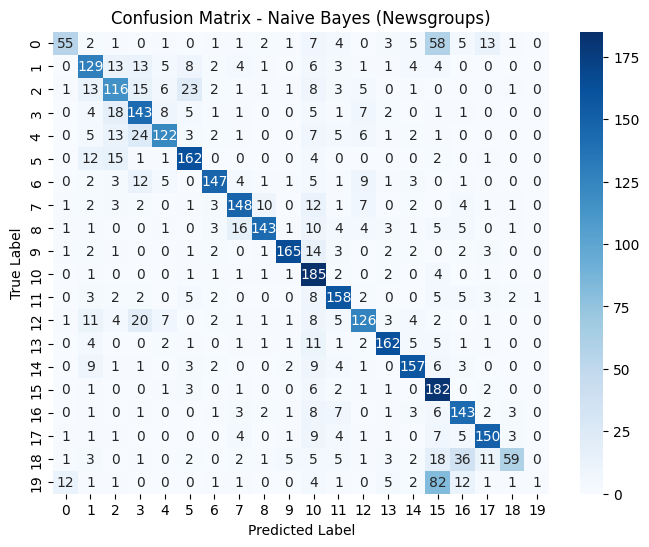

In [30]:
# 1. Naive Bayes (Multiclass)
print("\n1. Naive Bayes Classifier (TF-IDF features)")
nb_model_news = MultinomialNB()
nb_model_news.fit(news_train_tfidf, news_train['label'])
nb_preds_news = nb_model_news.predict(news_test_tfidf)
nb_metrics_news = evaluate_model(news_test['label'], nb_preds_news,
                               model_name="Naive Bayes (Newsgroups)", is_binary=False)


2. Support Vector Machine (TF-IDF features)

SVM (Newsgroups) Evaluation Metrics:
Accuracy: 0.6997
Precision: 0.7122
Recall: 0.6997
Sensitivity: 0.6997
F1 Score: 0.7008

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.57      0.56       160
           1       0.63      0.73      0.68       194
           2       0.61      0.61      0.61       197
           3       0.64      0.64      0.64       197
           4       0.73      0.62      0.67       192
           5       0.80      0.75      0.77       198
           6       0.83      0.72      0.77       195
           7       0.45      0.77      0.57       198
           8       0.73      0.74      0.74       199
           9       0.87      0.81      0.84       199
          10       0.94      0.84      0.89       200
          11       0.83      0.74      0.78       198
          12       0.56      0.66      0.61       197
          13       0.83      0.79      0.81      

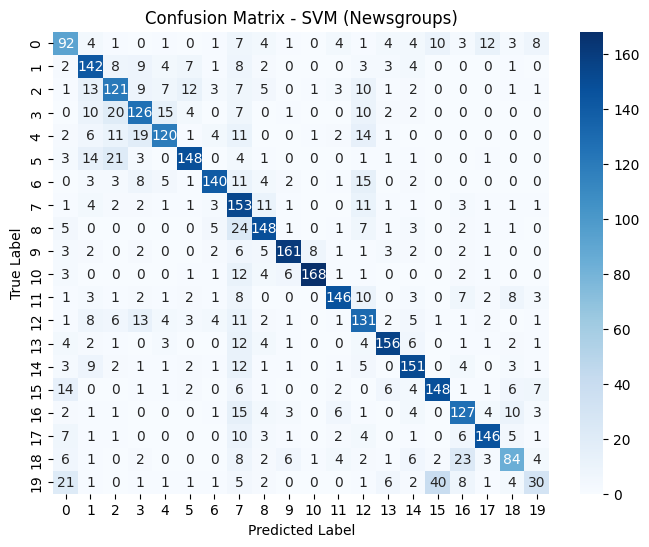

In [31]:
# 2. SVM (Multiclass)
print("\n2. Support Vector Machine (TF-IDF features)")
svm_model_news = SVC(kernel='linear')
svm_model_news.fit(news_train_tfidf, news_train['label'])
svm_preds_news = svm_model_news.predict(news_test_tfidf)
svm_metrics_news = evaluate_model(news_test['label'], svm_preds_news,
                                model_name="SVM (Newsgroups)", is_binary=False)


3. Logistic Regression (TF-IDF features)

Logistic Regression (Newsgroups) Evaluation Metrics:
Accuracy: 0.7090
Precision: 0.7159
Recall: 0.7090
Sensitivity: 0.7090
F1 Score: 0.7065

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       160
           1       0.62      0.68      0.65       194
           2       0.59      0.62      0.61       197
           3       0.68      0.62      0.65       197
           4       0.74      0.67      0.70       192
           5       0.77      0.75      0.76       198
           6       0.81      0.77      0.79       195
           7       0.77      0.76      0.76       198
           8       0.50      0.79      0.62       199
           9       0.86      0.80      0.83       199
          10       0.89      0.86      0.88       200
          11       0.87      0.75      0.81       198
          12       0.59      0.69      0.63       197
          13       0.79      0.81   

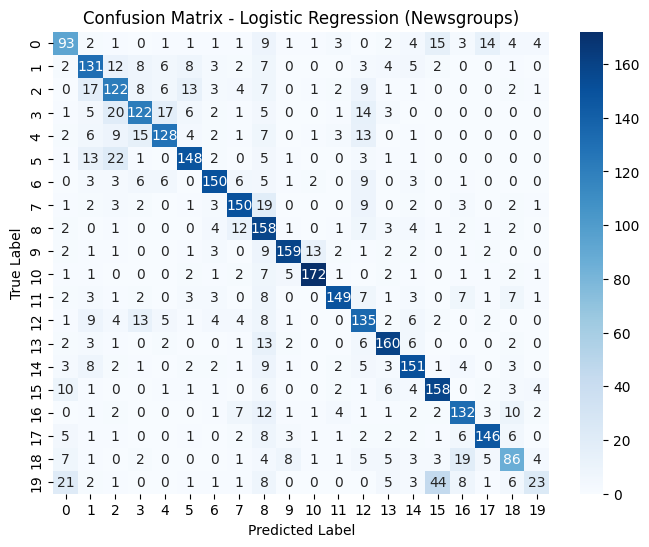

In [32]:
# 3. Logistic Regression (Multiclass)
print("\n3. Logistic Regression (TF-IDF features)")
lr_model_news = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_model_news.fit(news_train_tfidf, news_train['label'])
lr_preds_news = lr_model_news.predict(news_test_tfidf)
lr_metrics_news = evaluate_model(news_test['label'], lr_preds_news,
                              model_name="Logistic Regression (Newsgroups)", is_binary=False)

In [33]:
# 4. Neural Network (Multiclass)
num_classes = len(np.unique(news_train['label']))

# Build the neural network for multiclass classification
nn_model_news = Sequential([
    Dense(256, activation='relu', input_shape=(news_train_w2v.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

nn_model_news.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Train the model
history_news = nn_model_news.fit(
    news_train_w2v, news_train['label'],
    validation_data=(news_val_w2v, news_val['label']),
    epochs=100,
    batch_size=64,
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1271 - loss: 2.7819 - val_accuracy: 0.2982 - val_loss: 2.1453
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2501 - loss: 2.2303 - val_accuracy: 0.3454 - val_loss: 1.9565
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2978 - loss: 2.0802 - val_accuracy: 0.3577 - val_loss: 1.9313
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3026 - loss: 2.0557 - val_accuracy: 0.3722 - val_loss: 1.9121
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3138 - loss: 2.0361 - val_accuracy: 0.3776 - val_loss: 1.8597
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3444 - loss: 1.9848 - val_accuracy: 0.3839 - val_loss: 1.8523
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3447 - loss: 1.9461 - val_accuracy: 0.3924 - val_loss: 1.8313
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3539 - loss: 1.9576 - val_accu

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Neural Network (Newsgroups) Evaluation Metrics:
Accuracy: 0.4459
Precision: 0.4763
Recall: 0.4459
Sensitivity: 0.4459
F1 Score: 0.4349

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.19      0.23       160
           1       0.40      0.37      0.38       194
           2       0.50      0.45      0.47       197
           3       0.45      0.40      0.42       197
           4       0.28      0.24      0.26       192
           5       0.53      0.68      0.59       198
           6       0.74      0.57      0.65       195
           7       0.27      0.52      0.36       198
           8       0.41      0.29      0.34       199
           9       0.45      0.55      0.49       199
          10       0.66      0.52      0.58       200
          11       0.70      0.56      0.62       198
          12       0.36      0.35      0.35       197
          13       0.42      0.55      0.4

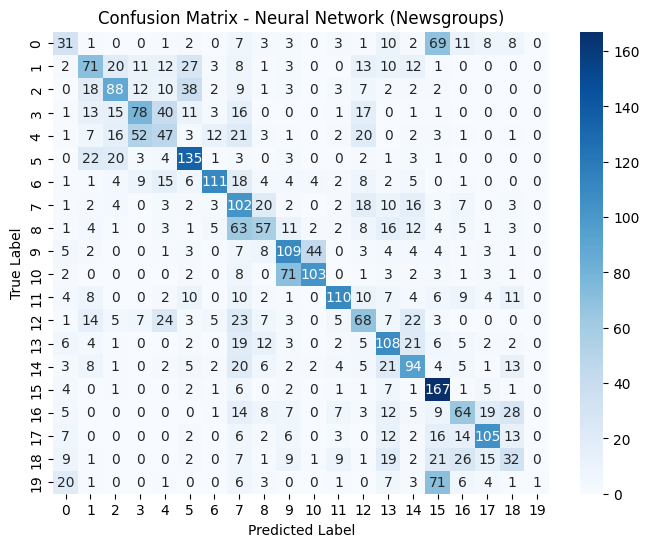

In [35]:
# Evaluate the model
nn_preds_news = nn_model_news.predict(news_test_w2v)
nn_preds_news_classes = np.argmax(nn_preds_news, axis=1)
nn_metrics_news = evaluate_model(news_test['label'], nn_preds_news_classes,
                              model_name="Neural Network (Newsgroups)", is_binary=False)

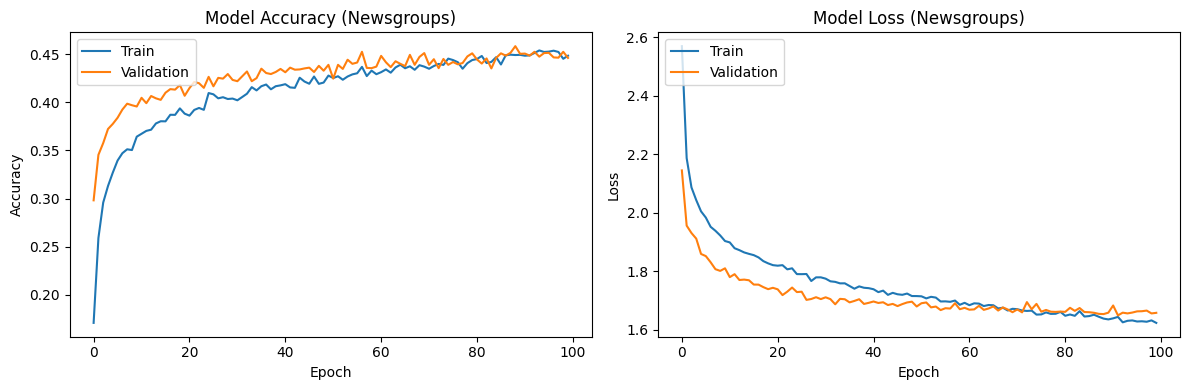

In [36]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_news.history['accuracy'])
plt.plot(history_news.history['val_accuracy'])
plt.title('Model Accuracy (Newsgroups)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_news.history['loss'])
plt.plot(history_news.history['val_loss'])
plt.title('Model Loss (Newsgroups)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

## Comparison of SMS spam Detection Models


===== SMS Spam Detection Model Comparison =====


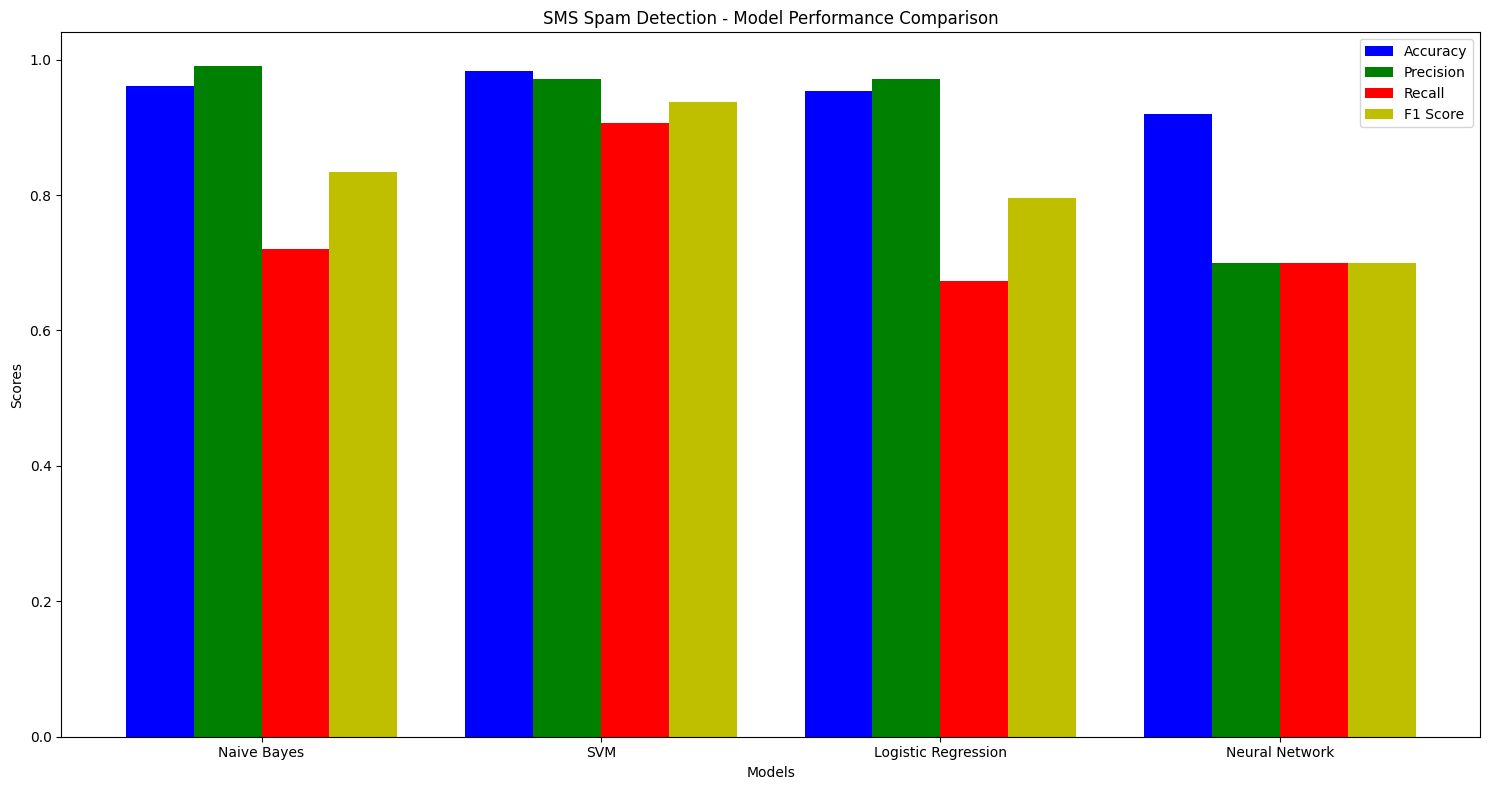

In [37]:
# Comparison of SMS spam detection models
print("\n===== SMS Spam Detection Model Comparison =====")
models_sms = ['Naive Bayes', 'SVM', 'Logistic Regression', 'Neural Network']
accuracy_sms = [nb_metrics['accuracy'], svm_metrics['accuracy'],
                lr_metrics['accuracy'], nn_metrics['accuracy']]
precision_sms = [nb_metrics['precision'], svm_metrics['precision'],
                 lr_metrics['precision'], nn_metrics['precision']]
recall_sms = [nb_metrics['recall'], svm_metrics['recall'],
              lr_metrics['recall'], nn_metrics['recall']]
f1_sms = [nb_metrics['f1'], svm_metrics['f1'],
          lr_metrics['f1'], nn_metrics['f1']]

plt.figure(figsize=(15, 8))
bar_width = 0.2
index = np.arange(len(models_sms))

plt.bar(index, accuracy_sms, bar_width, label='Accuracy', color='b')
plt.bar(index + bar_width, precision_sms, bar_width, label='Precision', color='g')
plt.bar(index + 2*bar_width, recall_sms, bar_width, label='Recall', color='r')
plt.bar(index + 3*bar_width, f1_sms, bar_width, label='F1 Score', color='y')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('SMS Spam Detection - Model Performance Comparison')
plt.xticks(index + 1.5*bar_width, models_sms)
plt.legend()
plt.tight_layout()
plt.show()

## Comparison of NewsGroups Detection Models

===== 20 Newsgroups Classification Model Comparison =====


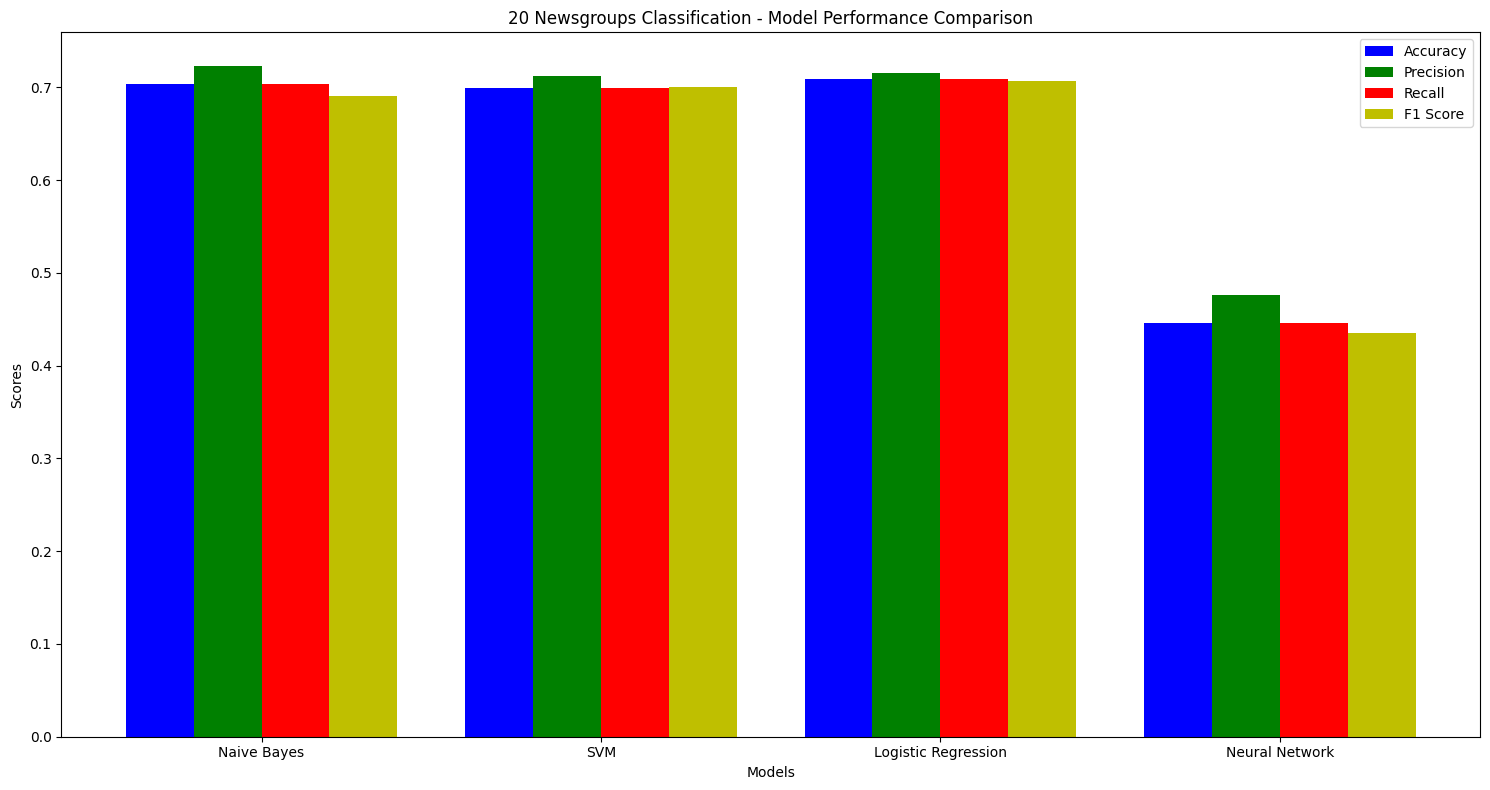

In [38]:
# Comparison of Newsgroups classification models
print("===== 20 Newsgroups Classification Model Comparison =====")
models_news = ['Naive Bayes', 'SVM', 'Logistic Regression', 'Neural Network']
accuracy_news = [nb_metrics_news['accuracy'], svm_metrics_news['accuracy'],
                 lr_metrics_news['accuracy'], nn_metrics_news['accuracy']]
precision_news = [nb_metrics_news['precision'], svm_metrics_news['precision'],
                  lr_metrics_news['precision'], nn_metrics_news['precision']]
recall_news = [nb_metrics_news['recall'], svm_metrics_news['recall'],
               lr_metrics_news['recall'], nn_metrics_news['recall']]
f1_news = [nb_metrics_news['f1'], svm_metrics_news['f1'],
           lr_metrics_news['f1'], nn_metrics_news['f1']]

plt.figure(figsize=(15, 8))
plt.bar(index, accuracy_news, bar_width, label='Accuracy', color='b')
plt.bar(index + bar_width, precision_news, bar_width, label='Precision', color='g')
plt.bar(index + 2*bar_width, recall_news, bar_width, label='Recall', color='r')
plt.bar(index + 3*bar_width, f1_news, bar_width, label='F1 Score', color='y')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('20 Newsgroups Classification - Model Performance Comparison')
plt.xticks(index + 1.5*bar_width, models_news)
plt.legend()
plt.tight_layout()
plt.show()

## Summary of Results

In [39]:
print("===== Summary of Results =====")
print("\nSMS Spam Detection Results:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print('-' * 60)
print(f"{'Naive Bayes':<20} {nb_metrics['accuracy']:<10.4f} {nb_metrics['precision']:<10.4f} {nb_metrics['recall']:<10.4f} {nb_metrics['f1']:<10.4f}")
print(f"{'SVM':<20} {svm_metrics['accuracy']:<10.4f} {svm_metrics['precision']:<10.4f} {svm_metrics['recall']:<10.4f} {svm_metrics['f1']:<10.4f}")
print(f"{'Logistic Regression':<20} {lr_metrics['accuracy']:<10.4f} {lr_metrics['precision']:<10.4f} {lr_metrics['recall']:<10.4f} {lr_metrics['f1']:<10.4f}")
print(f"{'Neural Network':<20} {nn_metrics['accuracy']:<10.4f} {nn_metrics['precision']:<10.4f} {nn_metrics['recall']:<10.4f} {nn_metrics['f1']:<10.4f}")

print("\n20 Newsgroups Classification Results:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print('-' * 60)
print(f"{'Naive Bayes':<20} {nb_metrics_news['accuracy']:<10.4f} {nb_metrics_news['precision']:<10.4f} {nb_metrics_news['recall']:<10.4f} {nb_metrics_news['f1']:<10.4f}")
print(f"{'SVM':<20} {svm_metrics_news['accuracy']:<10.4f} {svm_metrics_news['precision']:<10.4f} {svm_metrics_news['recall']:<10.4f} {svm_metrics_news['f1']:<10.4f}")
print(f"{'Logistic Regression':<20} {lr_metrics_news['accuracy']:<10.4f} {lr_metrics_news['precision']:<10.4f} {lr_metrics_news['recall']:<10.4f} {lr_metrics_news['f1']:<10.4f}")
print(f"{'Neural Network':<20} {nn_metrics_news['accuracy']:<10.4f} {nn_metrics_news['precision']:<10.4f} {nn_metrics_news['recall']:<10.4f} {nn_metrics_news['f1']:<10.4f}")


===== Summary of Results =====

SMS Spam Detection Results:
Model                Accuracy   Precision  Recall     F1 Score  
------------------------------------------------------------
Naive Bayes          0.9614     0.9908     0.7200     0.8340    
SVM                  0.9839     0.9714     0.9067     0.9379    
Logistic Regression  0.9534     0.9712     0.6733     0.7953    
Neural Network       0.9193     0.7000     0.7000     0.7000    

20 Newsgroups Classification Results:
Model                Accuracy   Precision  Recall     F1 Score  
------------------------------------------------------------
Naive Bayes          0.7037     0.7233     0.7037     0.6911    
SVM                  0.6997     0.7122     0.6997     0.7008    
Logistic Regression  0.7090     0.7159     0.7090     0.7065    
Neural Network       0.4459     0.4763     0.4459     0.4349    


## Conclusion

This assignment implements text classification on two datasets: SMS Spam Collection and 20 Newsgroups. It covers data preprocessing, feature extraction (TF-IDF, Word2Vec), and multiple classification models, including Naïve Bayes, SVM, Logistic Regression, and deep learning with TensorFlow. Performance is analyzed using various metrics. The results highlight the effectiveness of different models for spam detection and news categorization.

**Most accurate for Spam dataset was SVM (Support Vector Machines).**

**Most accurate for Newsgroups dataset was Logistic Regression only 0.0053 greater in accuracy than Naive Bayes.**

